# Multi Head Attention with Routing Algorithm

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

## Preparing the Data

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Libraries to create tokenizers.

In [ ]:
! python -m spacy download de

In [ ]:
! python -m spacy download en

Creating Tokenizers

In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Loading the Multi30k dataset and building the vocabulary.

In [5]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Define the device and the data iterator.

In [6]:
device = torch.device('cuda:0')

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Building the Model

The Model is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English).


# ENCODER

In [7]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

## Routing Class 

We have used the official implementation of the routing algorithm proposed by "An
    Algorithm for Routing Capsules in All Domains" (Heinsen, 2019).

Input:
        a_inp: [..., n_inp] input scores
        mu_inp: [..., n_inp, d_cov, d_inp] capsules of shape d_cov x d_inp

Output:
        a_out: [..., n_out] output scores
        mu_out: [..., n_out, d_cov, d_out] capsules of shape d_cov x d_out
        sig2_out: [..., n_out, d_cov, d_out] variances of shape d_cov x d_out

In [9]:
class Routing(nn.Module):
    
    def __init__(self, d_cov, d_inp, d_out, n_inp=-1, n_out=-1, n_iters=3, single_beta=False, eps=1e-5):
        super().__init__()
        self.n_iters, self.eps = (n_iters, eps)
        self.n_inp_is_fixed, self.n_out_is_fixed = (n_inp > 0, n_out > 0)
        one_or_n_inp, one_or_n_out = (max(1, n_inp), max(1, n_out))
        self.register_buffer('CONST_one', torch.tensor(1.0))
        self.W = nn.Parameter(torch.empty(one_or_n_inp, one_or_n_out, d_inp, d_out).normal_() / d_inp)
        self.B = nn.Parameter(torch.zeros(one_or_n_inp, one_or_n_out, d_cov, d_out))
        self.beta_use = nn.Parameter(torch.zeros(one_or_n_inp, one_or_n_out))
        self.beta_ign = self.beta_use if single_beta else nn.Parameter(torch.zeros(one_or_n_inp, one_or_n_out))
        self.f = nn.Sigmoid()
        self.log_f = nn.LogSigmoid()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, a_inp, mu_inp):
        n_inp = a_inp.shape[-1]
        n_out = self.W.shape[1] if self.n_out_is_fixed else n_inp
        W = self.W
        W = W if self.n_inp_is_fixed else W.expand(n_inp, -1, -1, -1)
        W = W if self.n_out_is_fixed else W.expand(-1, n_out, -1, -1)
        V = torch.einsum('ijdh,...icd->...ijch', W, mu_inp) + self.B
        for iter_num in range(self.n_iters):

            # E-step.
            if iter_num == 0:
                R = (self.CONST_one / n_out).expand(V.shape[:-2])  # [...ij]
            else:
                log_p_simplified = \
                    - torch.einsum('...ijch,...jch->...ij', V_less_mu_out_2, 1.0 / (2.0 * sig2_out)) \
                    - sig2_out.sqrt().log().sum((-2, -1)).unsqueeze(-2)
                R = self.softmax(self.log_f(a_out).unsqueeze(-2) + log_p_simplified)  # [...ij]

            # D-step.
            f_a_inp = self.f(a_inp).unsqueeze(-1)  # [...i1]
            D_use = f_a_inp * R
            D_ign = f_a_inp - D_use

            # M-step.
            a_out = (self.beta_use * D_use).sum(dim=-2) - (self.beta_ign * D_ign).sum(dim=-2)  # [...j]
            over_D_use_sum = 1.0 / (D_use.sum(dim=-2) + self.eps)  # [...j]
            mu_out = torch.einsum('...ij,...ijch,...j->...jch', D_use, V, over_D_use_sum)
            V_less_mu_out_2 = (V - mu_out.unsqueeze(-4)) ** 2  # [...ijch]
            sig2_out = torch.einsum('...ij,...ijch,...j->...jch', D_use, V_less_mu_out_2, over_D_use_sum) + self.eps

        return a_out, mu_out, sig2_out

# Mutli Head Attention Layer

In [10]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        self.device = device
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        #fc_q, fc_k, fc_v and fc_o are the linear layers
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        self.routing = Routing(d_cov=8, d_inp=32, d_out=32)#Initiate Routing Class

    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        attn_matmul = torch.matmul(self.dropout(attention), V)
        
        #attn_matmul = [batch size, n heads, query len, head dim]
        
        concat_attention = attn_matmul.permute(0, 2, 1, 3).contiguous()
        mu = concat_attention.to(torch.float)
        a = torch.ones(mask.shape[0], mu.shape[1]).to(self.device)
        #concat_attention = [batch size, query len, n heads, head dim]
    
        a, mu_out, sig2 = self.routing(a.cuda(), mu.cuda())
        mu_out = mu_out.view(batch_size, -1, self.hid_dim)

        
        #mu_out = [batch size, query len, hid dim]
        
        return mu_out, attention

## Position-wise Feedforward Layer

The other main block inside the encoder layer is the *position-wise feedforward layer* This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

In [11]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        
        #input = [batch size, seq len, hid dim]
        
        conv_hid_to_pf = self.dropout(torch.relu(self.fc_1(input)))
        
        #conv_hid_to_pf = [batch size, seq len, pf dim]
        
        conv_hid_to_pf = self.fc_2(conv_hid_to_pf)
        
        #conv_hid_to_pf = [batch size, seq len, hid dim]
        
        return conv_hid_to_pf


# Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 


In [12]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

## Decoder Layer

The decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`. 


In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq 

The `Seq2Seq` module encapsulates the encoder and decoder, as well as handling the creation of the masks.


In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention


# Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

### Model Initialization

In [16]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)


In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);


Defining Learning Rate and Optimizer

In [18]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)


Defining Loss function

In [19]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Method for Calculating Accuracy

In [20]:
def calc_accuracy(output, trg):
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(output, trg)]
    acc = matches.count(True)/len(matches)
    return acc

Method for Model Training

In [21]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


The evaluation of Model

In [22]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    outputs = []
    targets = []

    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
          
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

Defining a small function to show how much time an epoch takes.

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train Actual model

In [24]:
NO_OF_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')
train_losses_for_each_epochs = []

for epoch in range(NO_OF_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    train_loss = round(train_loss,2)
    train_losses_for_each_epochs.append(train_loss)


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f"Train losses for {NO_OF_EPOCHS} epochs {train_losses_for_each_epochs}")



Epoch: 01 | Time: 2m 15s
	Train Loss: 3.62 | Train PPL:  37.338
	 Val. Loss: 2.623 |  Val. PPL:  13.781
Train losses for 20 epochs [3.62]
Epoch: 02 | Time: 2m 11s
	Train Loss: 2.37 | Train PPL:  10.697
	 Val. Loss: 2.037 |  Val. PPL:   7.665
Train losses for 20 epochs [3.62, 2.37]
Epoch: 03 | Time: 2m 18s
	Train Loss: 1.82 | Train PPL:   6.172
	 Val. Loss: 1.714 |  Val. PPL:   5.554
Train losses for 20 epochs [3.62, 2.37, 1.82]
Epoch: 04 | Time: 2m 15s
	Train Loss: 1.43 | Train PPL:   4.179
	 Val. Loss: 1.518 |  Val. PPL:   4.562
Train losses for 20 epochs [3.62, 2.37, 1.82, 1.43]
Epoch: 05 | Time: 2m 14s
	Train Loss: 1.14 | Train PPL:   3.127
	 Val. Loss: 1.382 |  Val. PPL:   3.983
Train losses for 20 epochs [3.62, 2.37, 1.82, 1.43, 1.14]
Epoch: 06 | Time: 2m 16s
	Train Loss: 0.92 | Train PPL:   2.509
	 Val. Loss: 1.297 |  Val. PPL:   3.659
Train losses for 20 epochs [3.62, 2.37, 1.82, 1.43, 1.14, 0.92]
Epoch: 07 | Time: 2m 14s
	Train Loss: 0.75 | Train PPL:   2.117
	 Val. Loss: 1.270

KeyboardInterrupt: 

Showing train losses for each epoch in a graph

ValueError: x and y must have same first dimension, but have shapes (20,) and (14,)

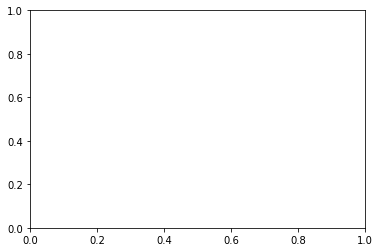

In [25]:
epochs = [item for item in range(0, 20)] 
plt.plot(epochs , train_losses_for_each_epochs)
plt.xlabel('Epochs')
plt.ylabel('Train losses')
plt.title('Epoch vs Loss Graph for Training Data')
plt.gcf()
plt.savefig('epoch_vs_train_loss.png')


### Show Final Test Loss

In [26]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.216 | Test PPL:   3.374 |


## Method for Translation

In [27]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

This method displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.


In [28]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [29]:
#First, we'll get an example from the training set.

example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [30]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['ballet', 'class', 'of', 'ballet', 'in', 'front', 'of', 'a', 'gate', '.', '<eos>']


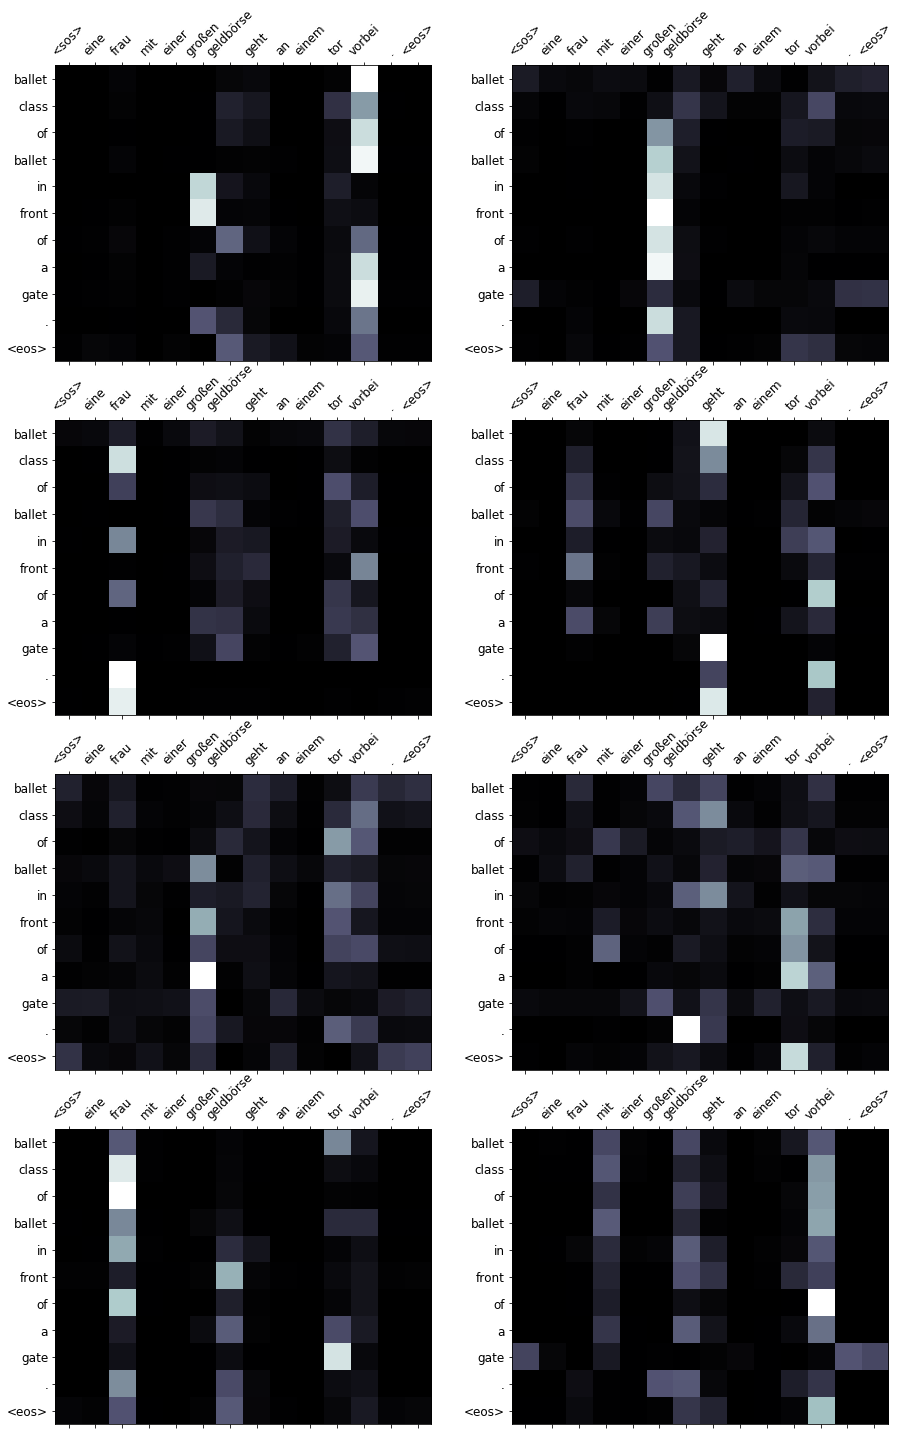

In [31]:
display_attention(src, translation, attention)

# BLEU

Calculating the BLEU score for the Transformer.

In [32]:
from nltk.translate.bleu_score import sentence_bleu

def get_bleu_score(test_data, source_field, target_field, model, device, max_len = 50):
    
    targets = []
    predicted_targets = []
    score = 0.0
    for data in test_data:
        
        source = vars(data)['src']
        target = vars(data)['trg']
        
        predicted_target, _ = translate_sentence(source, source_field, target_field, model, device, max_len)
        
        #cut off <eos> token
        predicted_target = predicted_target[:-1]
        
        predicted_targets.append(predicted_target)
        targets.append(target)
        each_target = [target]
        
        score += sentence_bleu(each_target, predicted_target)

    flat_pred_trgs = [item for sublist in predicted_targets for item in sublist]
    
    score = sentence_bleu(targets, flat_pred_trgs)* score
       
    return score

### Show BLEU Score

In [33]:
bleu_score = get_bleu_score(test_data, SRC, TRG, model, device)
# print(f'BLEU score = {bleu_score}')
print(f'BLEU score = {bleu_score*10:.2f}')

/home/aiman/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/aiman/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/aiman/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi

BLEU score = 0.12


Got BLEU Score : 60.69